In [52]:
import ctypes
try:
    ctypes.CDLL('/home/jupyter/cuda-11.7/lib64/libcudart.so')
    print("Successfully loaded libcudart.so")
except OSError as e:
    print("Error loading libcudart.so:", e)

try:
    ctypes.CDLL('/home/jupyter/cuda-11.7/lib64/libcudnn.so')
    print("Successfully loaded libcudnn.so")
except OSError as e:
    print("Error loading libcudnn.so:", e)


Error loading libcudart.so: Could not find module 'c:\home\jupyter\cuda-11.7\lib64\libcudart.so' (or one of its dependencies). Try using the full path with constructor syntax.
Error loading libcudnn.so: Could not find module 'c:\home\jupyter\cuda-11.7\lib64\libcudnn.so' (or one of its dependencies). Try using the full path with constructor syntax.


In [53]:
import os
import tensorflow as tf
os.environ['PATH'] = os.environ.get('PATH', '') + ':/home/jupyter/cuda-11.7/bin'
os.environ['LD_LIBRARY_PATH'] = os.environ.get('LD_LIBRARY_PATH', '') + ':/home/jupyter/cuda-11.7/lib64'

print("TensorFlow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

TensorFlow version: 2.16.1
Num GPUs Available:  0


In [54]:
!nvidia-smi

Mon May 27 22:28:26 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.85                 Driver Version: 555.85         CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4050 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   40C    P8              1W /   75W |      54MiB /   6141MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [55]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

TensorFlow version: 2.16.1
Num GPUs Available:  0


In [56]:
pip install librosa

Note: you may need to restart the kernel to use updated packages.


In [57]:
import pandas as pd
from sklearn.model_selection import train_test_split
from spectrograms import *
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, concatenate, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
import pandas as pd

### Tests on how to train a CNN using the data we have 775*308px

In [58]:
df = pd.read_csv('./birdclef-2024/train_metadata.csv')
df['filepath'] = './birdclef-2024/train_audio/' + df.filename
df['target'] = df.primary_label.map(CFG.name2label)
df['filename'] = df.filepath.map(lambda x: x.split('/')[-1])
df['xc_id'] = df.filepath.map(lambda x: x.split('/')[-1].split('.')[0])

train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)

In [59]:
train_df.head(3)

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,url,filename,filepath,target,xc_id
8932,eaywag1,[],[''],43.3479,4.7934,Motacilla flava,Western Yellow Wagtail,Stanislas Wroza,Creative Commons Attribution-NonCommercial-Sha...,2.0,https://xeno-canto.org/790724,XC790724.ogg,./birdclef-2024/train_audio/eaywag1/XC790724.ogg,53,XC790724
7578,comsan,[],['nocturnal flight call'],43.5352,-1.4475,Actitis hypoleucos,Common Sandpiper,Frédéric Cazaban,Creative Commons Attribution-NonCommercial-Sha...,5.0,https://www.xeno-canto.org/644516,XC644516.ogg,./birdclef-2024/train_audio/comsan/XC644516.ogg,44,XC644516
1918,bkskit1,[],"['call', 'female', 'flight call', 'male']",37.3823,-6.1363,Elanus caeruleus,Black-winged Kite,José Carlos Sires,Creative Commons Attribution-NonCommercial-Sha...,5.0,https://www.xeno-canto.org/353823,XC353823.ogg,./birdclef-2024/train_audio/bkskit1/XC353823.ogg,13,XC353823


In [60]:
df["target"].value_counts()

target
181    500
105    500
107    500
37     500
39     500
      ... 
16       6
178      6
119      5
5        5
92       5
Name: count, Length: 182, dtype: int64

In [61]:
target_counts = df['target'].value_counts()
print(len(target_counts[target_counts == 500]))

22


In [71]:
input_shape_img_rgb = (*CFG.img_size, 3)  # for RGB images
input_shape_img_bw = (*CFG.img_size, 1)  # for grayscale images

def create_model(input_shape_img, num_classes):
    img_input = Input(shape=input_shape_img, name='img_input')
    
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(img_input)
    x = MaxPooling2D((2, 2))(x)
    x = BatchNormalization()(x)
    
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = BatchNormalization()(x)
    
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = BatchNormalization()(x)
    
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    
    x = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=img_input, outputs=x)
    
    return model


In [72]:
input_shape_img_rgb = (*CFG.img_size, 3)  # for RGB images
input_shape_img_bw = (*CFG.img_size, 1)  # for grayscale images
input_shape_meta = (2,)  # for latitude and longitude
num_classes = CFG.num_classes

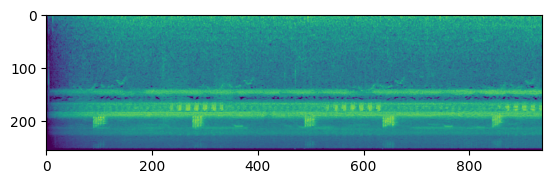

In [73]:
img_test = preprocess_audio('./birdclef-2024/train_audio/asbfly/XC305518.ogg', rgb=False)
plt.imshow(img_test, cmap='viridis')
plt.show()

In [74]:
model = create_model(input_shape_img_bw, num_classes)
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [75]:
img_test.shape

(256, 938)

In [76]:
input_shape_img_bw

(775, 308, 1)

In [83]:

train_generator = data_generator(train_df, batch_size, img_size=CFG.img_size, rgb=False)
test_generator = data_generator(test_df, batch_size, img_size=CFG.img_size, rgb=False)

# Test the generator
for _ in range(1):
    img_batch, target_batch = next(train_generator)
    print(f'Image batch shape: {img_batch.shape}')
    print(f'Target batch shape: {target_batch.shape}')
    break


Error processing ./birdclef-2024/train_audio/zitcis1/XC797410.ogg: melspectrogram() takes 0 positional arguments but 1 positional argument (and 1 keyword-only argument) were given
Error processing ./birdclef-2024/train_audio/kenplo1/XC765900.ogg: melspectrogram() takes 0 positional arguments but 1 positional argument (and 1 keyword-only argument) were given
Error processing ./birdclef-2024/train_audio/pursun4/XC453728.ogg: melspectrogram() takes 0 positional arguments but 1 positional argument (and 1 keyword-only argument) were given
Error processing ./birdclef-2024/train_audio/graher1/XC672787.ogg: melspectrogram() takes 0 positional arguments but 1 positional argument (and 1 keyword-only argument) were given
Error processing ./birdclef-2024/train_audio/grenig1/XC153284.ogg: melspectrogram() takes 0 positional arguments but 1 positional argument (and 1 keyword-only argument) were given
Error processing ./birdclef-2024/train_audio/eurcoo/XC554755.ogg: melspectrogram() takes 0 positiona

AttributeError: 'list' object has no attribute 'shape'

In [78]:
model.fit(train_generator, steps_per_epoch=len(train_df) // CFG.batch_size, epochs=CFG.epochs)

Error processing ./birdclef-2024/train_audio/comkin1/XC825364.ogg: melspectrogram() takes 0 positional arguments but 1 positional argument (and 1 keyword-only argument) were given
Error processing ./birdclef-2024/train_audio/gryfra/XC779860.ogg: melspectrogram() takes 0 positional arguments but 1 positional argument (and 1 keyword-only argument) were given
Error processing ./birdclef-2024/train_audio/whbbul2/XC163928.ogg: melspectrogram() takes 0 positional arguments but 1 positional argument (and 1 keyword-only argument) were given
Error processing ./birdclef-2024/train_audio/blhori1/XC816812.ogg: melspectrogram() takes 0 positional arguments but 1 positional argument (and 1 keyword-only argument) were given
Error processing ./birdclef-2024/train_audio/bcnher/XC805561.ogg: melspectrogram() takes 0 positional arguments but 1 positional argument (and 1 keyword-only argument) were given
Error processing ./birdclef-2024/train_audio/asikoe2/XC461634.ogg: melspectrogram() takes 0 positional

TypeError: `output_signature` must contain objects that are subclass of `tf.TypeSpec` but found <class 'list'> which is not.